In [273]:
!pip3 install textblob
!pip3 install wordcloud
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from wordcloud import WordCloud
from textblob import TextBlob

In [274]:
df = pd.read_csv("https://raw.githubusercontent.com/justtns/CNN-LSTM-Sentiment-Analysis-TSLA-Stock-Price-Forecasting/main/TSLA%20Tweets.csv")

In [275]:
df.head()

,Unnamed: 0,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,0,1546541426317590528,1545826164564000768,1.657559e+12,2022-07-11 17:06:24,0,NaN,@GailAlfarATX @elonmusk @Tesla @teslacn @Tesla...,en,[],...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'GailAlfarATX', 'name': 'Gail...",NaN,NaN,NaN,NaN
1,1,1546541415857102850,1545826164564000768,1.657559e+12,2022-07-11 17:06:21,0,NaN,@elonmusk @GailAlfarATX @Tesla @teslacn @Tesla...,en,[],...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'elonmusk', 'name': 'Elon Mus...",NaN,NaN,NaN,NaN
2,2,1546541411897581568,1546541411897581568,1.657559e+12,2022-07-11 17:06:20,0,NaN,"@elonmusk #Think about buying a country , #Mex...",en,"['think', 'mexico', 'constitution']",...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
3,3,1546541379110805508,1546340000500813824,1.657559e+12,2022-07-11 17:06:12,0,NaN,"@get_innocuous Actual receipts, and yet you ha...",en,[],...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'get_innocuous', 'name': 'tra...",NaN,NaN,NaN,NaN
4,4,1546541363470028800,1546541363470028800,1.657559e+12,2022-07-11 17:06:09,0,NaN,Tesla wall battery for the save! Power went ou...,en,[],...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN


In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10016 entries, 0 to 10015
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       10016 non-null  int64  
 1   id               10016 non-null  int64  
 2   conversation_id  10016 non-null  int64  
 3   created_at       10016 non-null  float64
 4   date             10016 non-null  object 
 5   timezone         10016 non-null  int64  
 6   place            4 non-null      object 
 7   tweet            10016 non-null  object 
 8   language         10016 non-null  object 
 9   hashtags         10016 non-null  object 
 10  cashtags         10016 non-null  object 
 11  user_id          10016 non-null  int64  
 12  user_id_str      10016 non-null  int64  
 13  username         10016 non-null  object 
 14  name             10015 non-null  object 
 15  day              10016 non-null  int64  
 16  hour             10016 non-null  int64  
 17  link        

# Data Cleaning:
1. Removing of irrelevant columns that do not affect the sentiment analysis, and will not be nessecary for the stock prediction. 
    - The only needed columns would be "tweet","user_id","user_id_str","date"
    - Important to note that before removing the Language column, it is important to remove all non "en" tweets

In [277]:
print(df["language"].nunique())

48


In [278]:
df_en = df[df["language"] == "en"]

In [279]:
df_en.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7358 entries, 0 to 10015
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       7358 non-null   int64  
 1   id               7358 non-null   int64  
 2   conversation_id  7358 non-null   int64  
 3   created_at       7358 non-null   float64
 4   date             7358 non-null   object 
 5   timezone         7358 non-null   int64  
 6   place            3 non-null      object 
 7   tweet            7358 non-null   object 
 8   language         7358 non-null   object 
 9   hashtags         7358 non-null   object 
 10  cashtags         7358 non-null   object 
 11  user_id          7358 non-null   int64  
 12  user_id_str      7358 non-null   int64  
 13  username         7358 non-null   object 
 14  name             7357 non-null   object 
 15  day              7358 non-null   int64  
 16  hour             7358 non-null   int64  
 17  link         

In [280]:
print(df_en["language"].nunique())

1


Now that only the english tweets are in the new dataframe, we will remove the irrelevant columns

In [281]:
df_use = df_en.filter(["user_id","user_id_str","tweet","date"], axis=1)

In [282]:
df_use.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7358 entries, 0 to 10015
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      7358 non-null   int64 
 1   user_id_str  7358 non-null   int64 
 2   tweet        7358 non-null   object
 3   date         7358 non-null   object
dtypes: int64(2), object(2)
memory usage: 287.4+ KB


Now that the FOR USE dataset has been created, we will now clean the tweets themselves

In [283]:
tweet_list=df_use["tweet"].values.tolist()

In [284]:
type(tweet_list)

list

In [285]:
def tweet_cleaner(tweet):
    if type(tweet) == np.float:
        return ""
    r = tweet.lower()
    r = re.sub("'", "", r) # This is to avoid removing contractions in english
    r = re.sub("@[A-Za-z0-9_]+","", r)
    r = re.sub("#[A-Za-z0-9_]+","", r)
    r = re.sub(r'http\S+', '', r)
    r = re.sub('[()!?]', ' ', r)
    r = re.sub('\[.*?\]',' ', r)
    r = re.sub("[^a-z0-9]"," ", r)
    r = r.split()
    stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
    r = [w for w in r if not w in stopwords]
    r = " ".join(word for word in r)
    return r

In [286]:
cleaned_tweets = [tweet_cleaner(i) for i in tweet_list]

/var/folders/5j/hyd6c6sj3pz7cp46wy9b3dbh0000gn/T/ipykernel_86489/683002274.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


In [287]:
cleaned_tweets

['i have six 4 them still live at home being homeschooled taught self education research beyond public education this nation has pushed society wrong direction change time',
 'then go your dozen kids you are just missing 3 more go it',
 'about buying country you could turn it into richest country world with trump as president all his people moving mexico with their own boot all cheap labor you would ever need',
 'actual receipts yet you haven t asked anyone buy you tesla grifters right probably rake 5k every 100 spent if you did set up gofund me this would be worthy cause',
 'tesla wall battery save power went out but can still run my ac when its about be 100',
 'sale 2021 used tesla model y standard range rear wheel drive autopilot midnight silver black 16 800 miles 64 900 lincoln nebraska',
 'about buying country you could turn it into richest country world with trump as president all his people moving mexico with their own boot all cheap labor you would ever need',
 'tsla not full m

In [288]:
sentiment_objects=[TextBlob(tweet) for tweet in cleaned_tweets]

In [289]:
sentiment_objects[0].polarity,sentiment_objects[0]

(-0.12121212121212122,
 TextBlob("i have six 4 them still live at home being homeschooled taught self education research beyond public education this nation has pushed society wrong direction change time"))

In [290]:
sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

In [291]:
sentiment_df=pd.DataFrame(sentiment_values,columns=["polarity","tweet"])

In [292]:
sentiment_df

,polarity,tweet
0,-0.121212,i have six 4 them still live at home being hom...
1,0.150000,then go your dozen kids you are just missing 3...
2,0.500000,about buying country you could turn it into ri...
3,0.129762,actual receipts yet you haven t asked anyone b...
4,0.000000,tesla wall battery save power went out but can...
...,...,...
7353,0.400000,elon musk liked tweet whole mars catalog tsla
7354,0.000000,dude only said he is buying twitter sell 8 bil...
7355,0.000000,give me your tesla
7356,0.233333,chick fil should definitely go public they sho...


In [293]:
pol = sentiment_df["polarity"]

In [294]:
pol_ser=pd.Series(pol)

In [295]:
pol_ser

0      -0.121212
1       0.150000
2       0.500000
3       0.129762
4       0.000000
          ...   
7353    0.400000
7354    0.000000
7355    0.000000
7356    0.233333
7357    0.100000
Name: polarity, Length: 7358, dtype: float64

In [296]:
pos=0
neg=0
neul=0

classification_str=[]
classification_score=[]

for items in pol_ser:
    if items>0:
        classification_str.append("Positive")
        classification_score.append(1)
        pos=pos+1
    elif items<0:
        classification_str.append("Negative")
        classification_score.append(-1)
        neg=neg+1
    else:

        classification_str.append("Neutral")
        classification_score.append(0)
        neu=neu+1
        
print(pos,neg,neu)

24108 9751 17647


In [297]:
df_classstr=pd.DataFrame(classification_str)

In [298]:
df_classscore=pd.DataFrame(classification_score)

In [299]:
df_classstr = df_classstr.rename(columns={0: 'Sentiment'})
df_classstr

,Sentiment
0,Negative
1,Positive
2,Positive
3,Positive
4,Neutral
...,...
7353,Positive
7354,Neutral
7355,Neutral
7356,Positive


In [300]:
df_classscore = df_classscore.rename(columns={0: 'Score'})
df_classscore

,Score
0,-1
1,1
2,1
3,1
4,0
...,...
7353,1
7354,0
7355,0
7356,1


In [301]:
extracted_col = df_classstr["Sentiment"]
  
df_use = df_use.join(extracted_col)
df_use

,user_id,user_id_str,tweet,date,Sentiment
0,1461585538532708356,1461585538532708356,@GailAlfarATX @elonmusk @Tesla @teslacn @Tesla...,2022-07-11 17:06:24,Negative
1,359051397,359051397,@elonmusk @GailAlfarATX @Tesla @teslacn @Tesla...,2022-07-11 17:06:21,Positive
2,34705390,34705390,"@elonmusk #Think about buying a country , #Mex...",2022-07-11 17:06:20,Positive
3,148991533,148991533,"@get_innocuous Actual receipts, and yet you ha...",2022-07-11 17:06:12,Positive
4,2269847504,2269847504,Tesla wall battery for the save! Power went ou...,2022-07-11 17:06:09,Neutral
...,...,...,...,...,...
10010,1347985766497050625,1347985766497050625,Elon Musk liked a tweet from Whole Mars Catalo...,2022-07-11 04:12:57,NaN
10011,2712288400,2712288400,Dude only said he is buying twitter to sell 8 ...,2022-07-11 04:12:57,NaN
10012,1419219176980312065,1419219176980312065,Give me your Tesla,2022-07-11 04:12:57,NaN
10014,1354874948045725698,1354874948045725698,"Chick Fil A should definitely go public, they ...",2022-07-11 04:12:53,NaN


In [302]:
extracted_col = df_classscore["Score"]
  
df_use = df_use.join(extracted_col,how='left')
df_use

,user_id,user_id_str,tweet,date,Sentiment,Score
0,1461585538532708356,1461585538532708356,@GailAlfarATX @elonmusk @Tesla @teslacn @Tesla...,2022-07-11 17:06:24,Negative,-1.0
1,359051397,359051397,@elonmusk @GailAlfarATX @Tesla @teslacn @Tesla...,2022-07-11 17:06:21,Positive,1.0
2,34705390,34705390,"@elonmusk #Think about buying a country , #Mex...",2022-07-11 17:06:20,Positive,1.0
3,148991533,148991533,"@get_innocuous Actual receipts, and yet you ha...",2022-07-11 17:06:12,Positive,1.0
4,2269847504,2269847504,Tesla wall battery for the save! Power went ou...,2022-07-11 17:06:09,Neutral,0.0
...,...,...,...,...,...,...
10010,1347985766497050625,1347985766497050625,Elon Musk liked a tweet from Whole Mars Catalo...,2022-07-11 04:12:57,NaN,NaN
10011,2712288400,2712288400,Dude only said he is buying twitter to sell 8 ...,2022-07-11 04:12:57,NaN,NaN
10012,1419219176980312065,1419219176980312065,Give me your Tesla,2022-07-11 04:12:57,NaN,NaN
10014,1354874948045725698,1354874948045725698,"Chick Fil A should definitely go public, they ...",2022-07-11 04:12:53,NaN,NaN


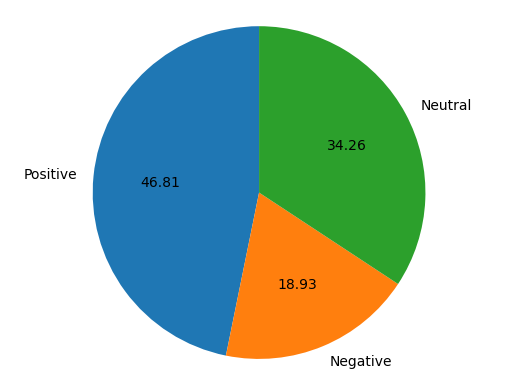

In [307]:
pieLabels=["Positive","Negative","Neutral"]

populationShare=[pos,neg,neu]

figureObject, axesObject = plt.subplots()

axesObject.pie(populationShare,labels=pieLabels,autopct='%1.2f',startangle=90)

axesObject.axis('equal')

plt.show()

In [306]:
print(pos, "percent of tweets are  positive about Tesla")

print(neg,"percent of tweets are  negative about Tesla")

print(neu,"percent of tweets are  neutral about Tesla")

24108 percent of tweets are  positive about Tesla
9751 percent of tweets are  negative about Tesla
17647 percent of tweets are  neutral about Tesla


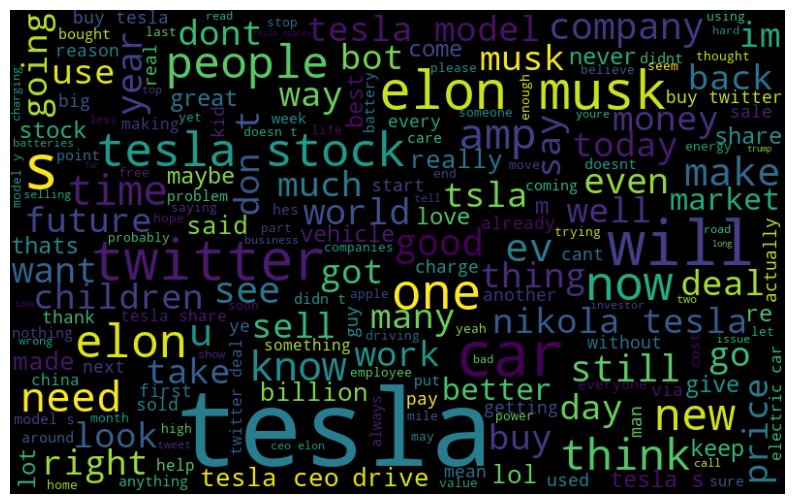

In [309]:

all_words = ' '.join([text for text in cleaned_tweets])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()